<img style="float: left;" alt="Drawing" src="./figures/3Di_beeldmerk_RGB.png" width="100"/> </td>
<img style="float: right;" alt="Drawing" src="./figures/lizard-beeldmerk-donker-groen.jpg" width="80"/> </td>                                                                                                                            

## Using 3Di and Lizard together in one Jupyter notebook

Welcome! In this notebook we will show how our two IT products <a href="https://3diwatermanagement.com/">3Di</a> and <a href="https://lizard.net/">Lizard</a> can be used together for an operational 3Di model. The following steps will be taken according to an example of an 3Di model:
- **step 1:** Starting a 3Di simulation by using the threedi-api
- **step 2:** Using radar rainfall date from Lizard for the simulation
- **step 3:** Downloading the results of the 3Di-simulation
- **step 4:** Analysing the results and validate with measurements from Lizard

For this tutorial we make use of the "BWN-Schermer" 3Di-model:


<img style="float: left;" alt="Drawing" src="./figures/3di_model_bwn_schermer.PNG" width="700"/> 

**Step 1: Starting a 3Di simulation by using the threedi-api**

Importing all required packages:

In [11]:
from datetime import datetime
from getpass import getpass
import pandas as pd
import json
from openapi_client import ApiException, SimulationsApi, OrganisationsApi
from openapi_client.api import AuthApi
from openapi_client.api import ThreedimodelsApi
from openapi_client.models import RasterEdit
from threedi_api_client.threedi_api_client import ThreediApiClient
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests

Provide credentials to connect to the threedi-api:

In [12]:
api_host = "https://api.3di.live/v3.0"
username = input("Username: ")
password = getpass("Password: ")
config = {
    "API_HOST": api_host,
    "API_USERNAME": username,
    "API_PASSWORD": password
}

api_client = ThreediApiClient(config=config)

Username: valerie.demetriades
Password: ········


Check the connection with the provided credentials:

In [13]:
auth_api = AuthApi(api_client)

try:
    user = auth_api.auth_profile_list()
except ApiException as e:
    print("Oops, something went wrong. Maybe you made a typo?")
else:
    print(f"Successfully logged in as {user.username}!")

ERROR
ERROR
Successfully logged in as valerie.demetriades!


Let's find the model:

In [14]:
models_api = ThreedimodelsApi(api_client)

models = models_api.threedimodels_list(name__icontains='bwn_schermer_1d2d_glg')
my_model =models.results[0]
my_model

{'breach_count': '0',
 'description': '',
 'disabled': False,
 'epsg': 28992,
 'extent_one_d': {'coordinates': [[4.746346127179737, 52.55681213186901],
                                  [4.888587808339217, 52.638657147508]],
                  'type': 'LineString'},
 'extent_two_d': {'coordinates': [[4.746025226172879, 52.55657076725733],
                                  [4.889009767284062, 52.63922057415133]],
                  'type': 'LineString'},
 'extent_zero_d': None,
 'id': 14916,
 'inp_success': True,
 'inpy_version': '3.0.26.7-1.4.20-1',
 'lines_count': 107682,
 'model_ini': 'bwn_schermer_1d2d_glg.ini',
 'name': 'bwn_schermer_1d2d_glg',
 'nodes_count': 53380,
 'repository_slug': 'bwn-schermer',
 'revision': 'https://api.3di.live/v3.0/revisions/3192/',
 'revision_commit_date': '2020-02-26T10:50:00Z',
 'revision_hash': '804f171ff4ec590f9e2aa40174feb9b5239513c5',
 'revision_number': '20',
 'slug': 'bwn-schermer-bwn_schermer_1d2d_glg-20-804f171ff4ec590f9e2aa40174feb9b5239513c5',


Let's see which organisations are available within my user account:

In [15]:
organisation_api = OrganisationsApi(api_client)

organisations = organisation_api.organisations_list()


for organisation in organisations.results:
    print(f"{organisation.name}: {organisation.unique_id}")

# In this example we use the organisation from N&S Demo:
organisation_uuid = "a1993f6e13564e9687ae03a3604463f9"

BWN HHNK: 48dac75bef8a42ebbb52e8f89bbdb9f2
City of Parramatta: 33b32fe8031743909ef9259744c32cc1
Course_A: 768684c9692f4a3695e014211d7fab41
Hoogheemraadschap Hollands Noorderkwartier: 474afd212f2e4b4f82615142f1d67acb
Nelen & Schuurmans: 61f5a464c35044c19bc7d4b42d7f58cb
N&S Demo: a1993f6e13564e9687ae03a3604463f9


The next step is to create a simulation. Note that it will not run yet.

In [16]:
simulation_api = SimulationsApi(api_client)

my_simulation = simulation_api.simulations_create(
    data={
        "name": "demo_3di_lizard_notebook_schermer",
        "threedimodel": my_model.id,
        "organisation": organisation_uuid,
        "start_datetime": datetime.now(),
        "duration": 10800  # in seconds, so we simulate for 3 hours
    }
)


#print an overview of the simulation
my_simulation


{'created': 'now',
 'duration': 10800,
 'duration_humanized': '3 hours, 0 minutes, 0 seconds',
 'end_datetime': datetime.datetime(2021, 2, 26, 17, 4, 4, tzinfo=tzutc()),
 'id': 13105,
 'name': 'demo_3di_lizard_notebook_schermer',
 'organisation': 'a1993f6e13564e9687ae03a3604463f9',
 'organisation_name': 'N&S Demo',
 'slug': 'demo_3di_lizard_notebook_schermer-d20846df-ce15-4564-b7e2-a9275860003e',
 'start_datetime': datetime.datetime(2021, 2, 26, 14, 4, 4, tzinfo=tzutc()),
 'tags': '[]',
 'threedimodel': 'https://api.3di.live/v3.0/threedimodels/14916/',
 'threedimodel_id': 14916,
 'url': 'https://api.3di.live/v3.0/simulations/13105/',
 'user': 'valerie.demetriades',
 'uuid': 'd20846df-ce15-4564-b7e2-a9275860003e'}

In [17]:
#check the status of the simulation with:
status = simulation_api.simulations_status_list(my_simulation.id)
print(status)

{'created': datetime.datetime(2021, 2, 26, 13, 4, 4, 172446, tzinfo=tzutc()),
 'exit_code': None,
 'id': 58923,
 'name': 'created',
 'paused': None,
 'time': 0.0}


We can see the simulation has not started yet. The options at the name of the status can be: "created", "started" and "finished".

**Step 2: Using radar rainfall data from Lizard for the simulation**

In previous step we created a simulation for the 3di model of v2_BWN Schermer. In this step we will add a rain event to the simulation and start the simulation. The rain event is extracted from the radar rainfall data within Lizard. We choose to simulate this specific date and time (15-11-2020 14:00 PM) and then extract the rainfall for 3 hours (until 17:00 PM). The simulation is also defined for 3 hours, which means the simulation stops immediately after the added rainfall event.

<table><tr>
<td> <img alt="Drawing" src="./figures/radar_rainfall_lizard.PNG" width="4000"/> </td>
</tr></table>


For this part, we also need to make a connection with the lizard api and we can use the same credentials as for the 3di part:

In [42]:
username = input("Enter username: ")
password = getpass("Enter password: ")
headers = {
            "username": username,
            "password": password,
            "Content-Type": "application/json",
        }

Enter username: valerie.demetriades
Enter password: ········


Now we have to define the starttime, endtime and duration of the chosen rainfall event and the uuid of the rainfall raster within Lizard:

In [25]:
#define start- and endtime of the radar rainfall data
start = datetime(2020, 11, 15, 14, 00)
end = start + timedelta(hours=3)
duration = end - start
print ("Starttime of the radar rainfall event:", start)
print ("Endtime of the radar rainfall event:", end)
print ("Duration of the radar rainfall event in seconds:", duration.total_seconds(), "seconds")

uuid = "730d6675-35dd-4a35-aa9b-bfb8155f9ca7"
print ("Raster rainfall uuid of Lizard:", uuid)

Starttime of the radar rainfall event: 2020-11-15 14:00:00
Endtime of the radar rainfall event: 2020-11-15 17:00:00
Duration of the radar rainfall event in seconds: 10800.0 seconds
Raster rainfall uuid of Lizard: 730d6675-35dd-4a35-aa9b-bfb8155f9ca7


Next step is to add this event to the created simulation in step 1 by making use of the threedi open api client:

In [28]:
#Upload radar rainfall from Lizard and wait for it to be processed
simulation_api.simulations_events_rain_rasters_lizard_create(
            my_simulation.id,
            data={
                "offset": 0,
                "duration": int(duration.total_seconds()),
                "reference_uuid": uuid,
                "start_datetime": start,
                "units": "m/s",
            },
        )

{'duration': 10800,
 'id': 1565,
 'interval': 300,
 'multiplier': 1.0,
 'offset': 0,
 'origin_offset': 0,
 'reference_uuid': '730d6675-35dd-4a35-aa9b-bfb8155f9ca7',
 'simulation': 'https://api.3di.live/v3.0/simulations/13105/',
 'start_datetime': datetime.datetime(2020, 11, 15, 14, 0, tzinfo=tzutc()),
 'store_path': 'rain',
 'uid': '7fd480b5-d4f7-4f39-8716-2fa496d88ff7',
 'units': 'm/s',
 'url': 'https://api.3di.live/v3.0/simulations/13105/events/rain/rasters/lizard/1565/',
 'user': 'valerie.demetriades'}

Let's print an overview of the added events to our simulation and check if the "lizardrasterrain" is not empty:

In [29]:
events = simulation_api.simulations_events(my_simulation.id)
print(events)

{'breach': [],
 'fileboundaryconditions': None,
 'filelaterals': [],
 'filerasterrain': [],
 'filerastersourcessinks': [],
 'filetimeseriesrain': [],
 'filetimeseriessourcessinks': [],
 'initial_groundwaterlevel': None,
 'initial_groundwaterraster': None,
 'initial_onedwaterlevel': None,
 'initial_onedwaterlevelpredefined': None,
 'initial_savedstate': None,
 'initial_twodwaterlevel': None,
 'initial_twodwaterraster': None,
 'initial_winddragcoefficient': None,
 'laterals': [],
 'lizardrasterrain': [{'duration': 10800,
                       'id': 1565,
                       'interval': 300,
                       'multiplier': 1.0,
                       'offset': 0,
                       'origin_offset': 0,
                       'reference_uuid': '730d6675-35dd-4a35-aa9b-bfb8155f9ca7',
                       'simulation': 'https://api.3di.live/v3.0/simulations/13105/',
                       'start_datetime': datetime.datetime(2020, 11, 15, 14, 0, tzinfo=tzutc()),
                

We can now run our simulation:

In [30]:
simulation_api.simulations_actions_create(my_simulation.id, data={"name": "start"})

{'duration': None, 'max_rate': None, 'name': 'start', 'timeout': 300}

And check the status of the simulation with:

In [40]:
#check the status of the simulation with:
status = simulation_api.simulations_status_list(my_simulation.id)
print(status)

{'created': datetime.datetime(2021, 2, 26, 13, 20, 9, 280804, tzinfo=tzutc()),
 'exit_code': None,
 'id': 58927,
 'name': 'initialized',
 'paused': False,
 'time': 0.0}


**Step 3: Downloading the results of the 3Di-simulation**

When our simulation has finished, it is time to analyse the results of the 3Di-model and validate the model with measurements from Lizard. Before that, we have to download all the results of the simulation. We select again the model and check if the status is finished:

In [ ]:
simulation_api = SimulationsApi(api_client)

simulation = simulation_api.simulations_list(
    name=my_simulation.name, user__username=username
).results[-2]
status = simulation_api.simulations_status_list(simulation.id)

print(simulation)
print(f"status: {status}")
assert status.name == 'finished'

Let's see which result files are available and download all the results of the simulation model in a local folder:

In [ ]:
result_files = simulation_api.simulations_results_files_list('12953')  #fill in the id of your simulation as above

for result in result_files.results:
    print(result)

In [ ]:
download_folder = Path(f'Results {my_simulation.name}')
download_folder.mkdir(exist_ok=True)

for file in result_files.results:
    download_url = simulation_api.simulations_results_files_download(
        id=file.id, simulation_pk=simulation.id
    )

    file_path = download_folder / file.filename
    r = requests.get(download_url.get_url)
    with open(file_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"Finished downloading {file.filename}")

In addition to the results of the 3Di-simulation, we also have to download the "gridadmin.h5" file of the simulation. This is a model specific file so it's under the threedimodels-api. We'll also download this file:

In [ ]:
model_api = ThreedimodelsApi(api_client)

threedi_model_id = simulation.threedimodel_id
download_url = model_api.threedimodels_gridadmin_download(threedi_model_id)

file_path = download_folder / "gridadmin.h5"
r = requests.get(download_url.get_url)
with open(file_path, "wb") as f:
    for chunk in r.iter_content(chunk_size=8192):
        f.write(chunk)

print(f"Finished downloading gridadmin.h5")

All the files are now on a local folder and we can go to the next step of validation.

**Analysing the results and validate with measurements from Lizard**

In [ ]:
#Import libraries
from threedigrid.admin.gridresultadmin import GridH5ResultAdmin
from threedigrid.admin.gridadmin import GridH5Admin
import os

In [ ]:
#Define paths and files
result_path = download_folder
nc = os.path.join(result_path,'results_3di.nc')
f = os.path.join(result_path,'gridadmin.h5')

#Load files into gr object
ga = GridH5Admin(f)
gr = GridH5ResultAdmin(f,nc)

In [ ]:
#deze plot nog veranderen met locatie van gemaal waar we de validatie voor gaan uitvoeren

In [ ]:
plt.figure()
#plotting only your 2d open water grid 
xyc = ga.nodes.subset('2d_open_water').coordinates
plt.plot(xyc[0], xyc[1], '.', label='2D open water')

#plotting your 1D grid
xyc = ga.nodes.subset('1D_ALL').coordinates
plt.plot(xyc[0], xyc[1], '.', label='1D all', color='green', markersize=4)

# Setting the axis right
plt.legend()
plt.axis('equal')
plt.axis('tight')
plt.title("2D Open water and 1D grid - 3Di simulation BWN Schermer", fontsize=20)

In [ ]:
#hier komt het stukje van het ophalen van de tijdserie waterlevel van het gemaal.

Let's perform a validation on the waterlevels of the pumping station Beatrix. The waterlevel timeseries of this pumping station are real-time available in the datawarehouse and analysis platform Lizard.

In [58]:
#extract the waterlevel timeseries from Lizard with the API

#Find the uuid of the timeseries you want to query
uuid = "09b5968e-9811-4539-89b3-738a4bbb6c4d"
# we're going to query request the data, similar to the simulation:
params= {'start':'2020-11-15T14:00:00Z', 'end':'2020-11-15T17:00:00Z', 'fields':'value', 'page_size':'10000000'} #Note that we use a page size of 100.
url = "https://nens.lizard.net/api/v4/timeseries/{}/events/".format(uuid)    

#Retrieve the 'results' attribute of the response using a JSON interpreter
time_series_events = pd.DataFrame(requests.get(url=url,headers=headers, params=params).json()['results'])

In [59]:
#perform some conversions before plotting the timeseries
time_series_events['datetime'] = pd.to_datetime(time_series_events['time'])
time_series_events = time_series_events[['datetime', 'value']]
time_series_events.set_index('datetime', inplace=True)

time_series_events

,value
datetime,
2020-11-15 14:00:00+00:00,-4.973
2020-11-15 14:15:00+00:00,-4.961
2020-11-15 14:30:00+00:00,-4.963
2020-11-15 14:45:00+00:00,-4.961
2020-11-15 15:00:00+00:00,-4.958
2020-11-15 15:15:00+00:00,-4.957
2020-11-15 15:30:00+00:00,-4.953
2020-11-15 15:45:00+00:00,-4.950
2020-11-15 16:00:00+00:00,-4.940


Text(0.5, 1.0, 'Pumping station Beatrix HHNK')

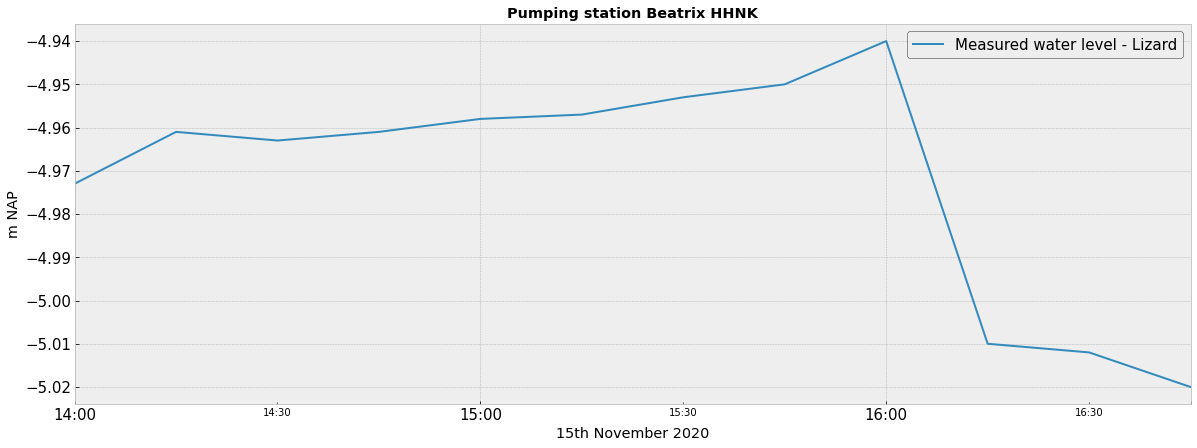

In [77]:
#plot the timeseries
plt.style.use('bmh')
time_series_events.plot(figsize=(20,7))
plt.xlabel('15th November 2020', fontsize='x-large')
plt.ylabel('m NAP', fontsize='x-large')
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.legend(["Measured water level - Lizard"], frameon=True, fontsize=15, edgecolor='k')
plt.title('Pumping station Beatrix HHNK', fontweight='bold')

In [ ]:
#in bovenstaande plot nog de modelled water level plotten

Ofcourse, the timeseries do not fully match. There is a certain state at the beginning of the simulation, that is not inside this simulation. It is however possible to also take this state into account.


**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**
The end

In this tutorial we showed you how 3Di and Lizard can be used together, by taking the following steps into account:
- how to start a simulation of a 3Di-model, 
- how to radar rainfall data from Lizard to your simulation, 
- how to download the results of the model simulation,
- and in the end how to visualise your model and validate simulation results with real-time data from Lizard.

This is all possible within a Jupyter notebook by making use of the API-v3 (3Di) and the REST-API from Lizard . Ofcourse there are a lot more options for the analysis (validation) possible. Or for the events you can add to your simulation. 

Do you want to learn more or are you interested in some more possible analysis in a jupyter notebook? 

**Please contact**:

Valerie Demetriades | valerie.demetriades@nelen-schuurmans.nl

Jonas van Schrojenstein | jonas.vanschrojenstein@nelen-schuurmans.nl
